Here, we consider the example of determining whether a coin is biased of not.
Example is taken from: http://people.duke.edu/~ccc14/sta-663-2016/16A_MCMC.html

Estimating the bias of two coins given sample pairs $(z_1,n_1)$ and $(z_2,n_2)$ where $z_i$ is the number of heads in $n_i$ tosses for coin i.

# Anayltical Solution:

In [29]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

In [21]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes."""
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)

In [22]:
def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [23]:
def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2.0
    thetas = xs[:-1]+ widths
    return thetas

In [37]:
from mpl_toolkits.mplot3d import Axes3D

def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
        for ax_ in ax: ax_._axis3don = False
    else:
        ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
        ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
        ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posterior')
    plt.tight_layout()
    fig.savefig('Size.png')

In [38]:
thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

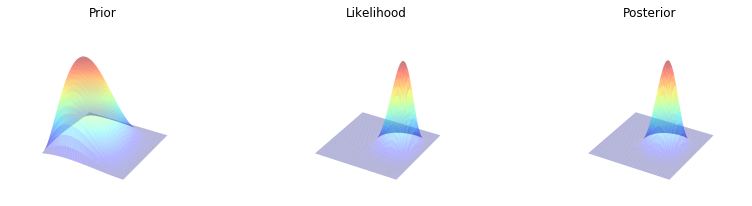

In [42]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)
#make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

# Gibbs Approximation:

In [43]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin,2), np.float)
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]

    if i >= burnin:
        thetas[i-burnin] = theta

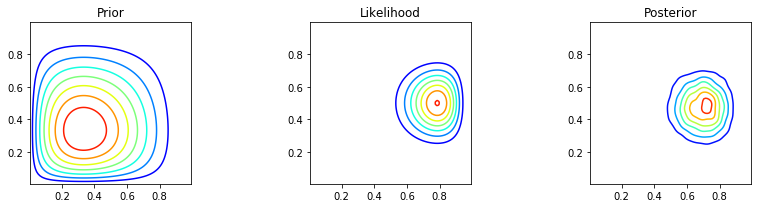

In [45]:
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
#make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')